In [22]:
import numpy as np
import matplotlib.pyplot as plt
import wiener_sampling as ws
import warnings

# Hide all Python warnings, numpy warnings. In order to turn warnings back on comment out the next two lines, restart the kernel and rerun the notebook. 
warnings.filterwarnings("ignore")
np.seterr(all="ignore")

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [23]:
# functions

def Snn_trial(w, N0=1e-2, A=5, b=1.8):
    return N0 + A / (np.abs(w)**b) 

a_b_trial = (0, 0.9)

def Sxx_trial(w, peak_amp=0.9, f_c=10.0, f_halfwidth=1.0):
    wc = 2*np.pi*f_c
    gamma = 2*np.pi*f_halfwidth
    peak = peak_amp * (gamma**2) / (((np.abs(w) - wc)**2) + gamma**2)
    return peak

In [24]:
def Sxx(w):
    return Sxx_trial(w)
def Snn(w):
    return Snn_trial(w)
def Sxy(w):
    return Sxx(w)
def Syy(w): 
    return Sxx(w) + Snn(w)

# preconditioning values
alpha, beta = a_b_trial

def F_factor(w):
    wc = np.asarray(w, dtype=np.complex128)
    return np.exp(-np.pi*1j * alpha/2) * (1j + wc)**(alpha - beta) * (wc**beta)

fs = 512
Nt = 16384*50
w_master = 2*np.pi*np.fft.fftfreq(Nt, d=1.0/fs)  
w = np.sort(w_master) 
Gamma = 0.1

In [25]:
# load previously ran data
with np.load("filter_snaps.npz") as data:
    Syy_causal = data["Syy"]
    H_causal   = data["H"]
    w       = data["w"]
    t       = data["t"]
    x_hat_stream = data["xhat"]
    x = data["x"]
    x_hat = data["x_hat"]
    y = data["y"]
    H_est = data["H_est"]
    H_no_sampling = data["H_no_sampling"]
    H_no_preconditioning = data["H_no_preconditioning"]
    H_non_causal = data["H_non_causal"]

Syy_est = ws.welch_on_grid(x, y, fs, Gamma, w_master, Nt)


In [26]:
# generating error PSDs using welch
eps_recorded = x-x_hat
eps_real_time = x-x_hat_stream

PSD_eps_recorded = ws.welch_on_grid(x, eps_recorded, fs, 0.5, w_master, Nt)
PSD_eps_real_time = ws.welch_on_grid(x, eps_real_time, fs, 0.5, w_master, Nt)

Syy_est_vals = Syy_est(w)

# smooth out PSD error function - average the data over log bins, remove outliers.
def error_psd_positive_binned_outlier(PSD, Syy, w, bins, z_thresh=20):
    num = PSD(w)
    den = Syy
    m = w > 0
    w, num, den = w[m], num[m], den[m]

    edges = np.logspace(np.log10(w.min()), np.log10(w.max()), bins+1)

    num_binned = np.zeros(len(edges)-1)
    den_binned = np.zeros(len(edges)-1)

    idx = np.digitize(w, edges)
    for i in range(1, len(edges)):
        mask = idx == i
        if not np.any(mask):
            num_binned[i-1] = np.nan
            den_binned[i-1] = np.nan
            continue

        num_bin = num[mask]
        den_bin = den[mask]

        med_num = np.mean(num_bin)
        mad_num = np.std(num_bin)
        keep_num = np.abs(num_bin - med_num) < z_thresh * mad_num
        num_bin = num_bin[keep_num]

        num_binned[i-1] = np.mean(num_bin)
        den_binned[i-1] = np.mean(den_bin)

    PSD_binned = num_binned/den_binned
    w_centers = np.sqrt(edges[:-1] * edges[1:])
    return w_centers, PSD_binned


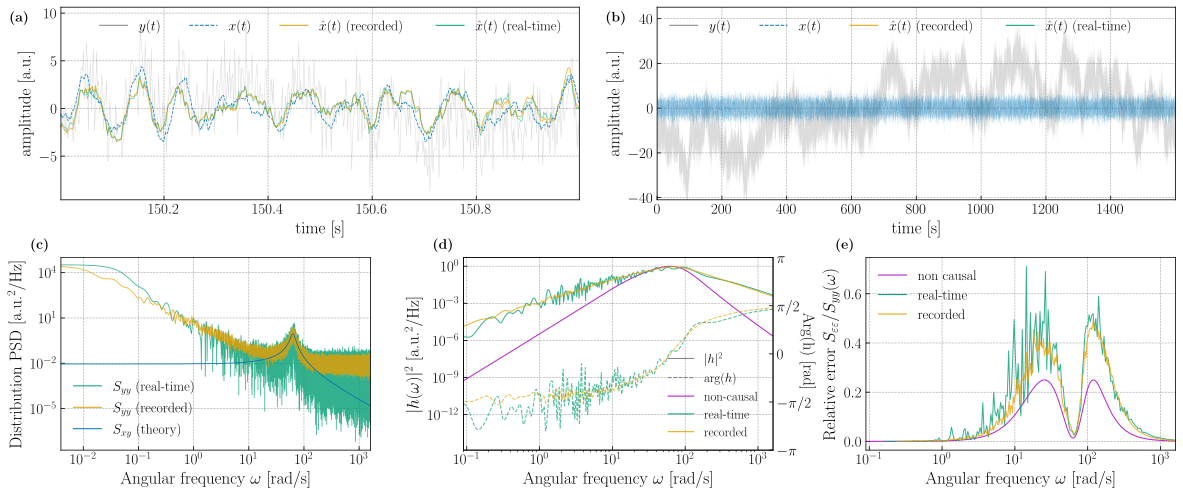

In [27]:
# pretty graph function for plotting

import matplotlib as mpl
import matplotlib.lines as mlines
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['axes.xmargin'] = 0            
mpl.rcParams['axes.ymargin'] = 0.05
%config InlineBackend.figure_format = 'svg'

plt.rcParams.update({
    "text.usetex": True,            
    "font.family": "serif",         
    "font.serif": ["Computer Modern"],
})


def pretty_graph(ax=None, x_label=None, y_label=None, title=None, location="best", ncol=1):

    ax.minorticks_off()
    ax.grid(True, which='major', color='gray', linestyle='--',
            linewidth=0.6, alpha=0.7)

    for side in ("top", "right"):
        ax.spines[side].set_linewidth(0.8)
    for side in ("left", "bottom"):
        ax.spines[side].set_linewidth(0.8)

    ax.tick_params(axis='both', which='major', length=4, width=0.8,
                   labelsize=15, direction='in', top=False, right=False)

    if x_label is not None:
        ax.set_xlabel(x_label, fontsize=17)
    if y_label is not None:
        ax.set_ylabel(y_label, fontsize=17)

    if title is not None:
        ax.set_title(title, fontsize=12, fontweight="bold", loc="center")

    leg = ax.legend(frameon=False, fontsize=14, loc=location, ncol=ncol)
    for line in leg.get_lines():
        line.set_alpha(1.0)
        line.set_linewidth(1.0)

    ax.figure.tight_layout(pad=0)
    return ax

# analytic error psd for non causal filter error 
def error_psd(h, w): 
    return (Sxx(w) + np.abs(h)**2 * Syy(w) - 2* np.real(np.conjugate(h) * Sxy(w)))/Syy(w)

def h_psd(h, w): 
    return np.abs(h)**2

a = 150
b = a + 1
m = (t > a) & (t < b)

# graph (a)
def zoom_series(ax):
    ax.plot(t[m], y[m], label=r'$y(t)$',                          linewidth=0.5, alpha=0.3, color='#7F7F7F')
    ax.plot(t[m], x[m], '--', label=r'$x(t)$',             linewidth=0.8, alpha = 0.9, color='#0072B2')
    ax.plot(t[m], x_hat[m], label=r'$\hat{x}(t)$ (recorded)',                  linewidth=0.8, alpha = 0.8, color='#E69F00')
    ax.plot(t[m], x_hat_stream[m], label=r'$\hat{x}(t)$ (real-time)',    linewidth=0.8, alpha = 0.5, color='#009E73')
    pretty_graph(ax, x_label='time [s]', y_label='amplitude [a.u.]', ncol=4)

# graph (b)
def total_series(ax):
    ax.plot(t, y, label=r'$y(t)$',                        linewidth=0.1, alpha=0.3, color='#7F7F7F')
    ax.plot(t, x, '--', label=r'$x(t)$',           linewidth=0.07, alpha = 0.7, color='#0072B2')
    ax.plot(t, x_hat, label=r'$\hat{x}(t)$ (recorded)',        linewidth=0.05, alpha = 0.5, color='#E69F00')
    ax.plot(t, x_hat_stream, label=r'$\hat{x}(t)$ (real-time)',  linewidth=0.03, alpha = 0.3, color='#009E73')
    ax.set_ylim(-41)
    pretty_graph(ax, x_label='time [s]', y_label='amplitude [a.u.]', location="upper left", ncol=4)

# graph (c)
def PSD_plot(ax):
    ax.loglog(w, Syy_causal, label=r"$S_{yy}$ (real-time)",          linewidth=0.8, alpha = 0.8, color='#009E73')
    ax.loglog(w, Syy_est(w), label=r"$S_{yy}$ (recorded)",         linewidth=0.8, alpha = 0.8, color='#E69F00')
    ax.loglog(w, Sxy(w), label=r"$S_{xy}$ (theory)",              linewidth=0.8, alpha = 1, color='#0072B2')
    ax.set_ylim(0,1e5)
    pretty_graph(ax, x_label=r'Angular frequency $\omega$ [rad/s]', y_label=r'Distribution PSD [a.u.$^2$/Hz]')

# graph (d)
def PSD_error(ax):
    ax.semilogx(w, error_psd(H_non_causal, w), label=r'non causal',    linewidth=1, alpha = 0.9, color="#AF0CC8")
    ax.semilogx(*error_psd_positive_binned_outlier(PSD_eps_real_time, Syy_causal, w, bins=300, z_thresh=10), label=r'real-time',       linewidth=1, alpha = 0.8, color='#009E73')
    ax.semilogx(*error_psd_positive_binned_outlier(PSD_eps_recorded, Syy_est_vals, w, bins=500, z_thresh=10), label=r'recorded',             linewidth=1, alpha = 0.8, color='#E69F00')
    ax.set_xlim(0.09)
    pretty_graph(ax, x_label=r'Angular frequency $\omega$ [rad/s]', y_label=r'Relative error $S_{\varepsilon\varepsilon}/S_{yy}(\omega)$')

# graph (e)

def PSD_h(ax):
    ax.loglog(w, h_psd(H_non_causal, w), label=r'non causal',  linewidth=1, alpha = 0.9, color="#AF0CC8")
    ax.loglog(w, h_psd(H_causal, w), label=r'real-time',     linewidth=1, alpha = 0.8, color='#009E73')
    ax.loglog(w, h_psd(H_est, w), label=r'recorded',           linewidth=1, alpha = 0.8, color='#E69F00')
    ax.set_xlim(0.09)
    ax.set_ylim(1e-10-1e-11)
    pretty_graph(ax, x_label=r'Angular frequency $\omega$ [rad/s]', y_label=r'$|h(\omega)|^2 $[a.u.$^2$/Hz]')

def PSD_h_new(ax):
    # ===== Magnitude (left axis) =====
    m1, = ax.loglog(w, h_psd(H_non_causal, w), label=r'non-causal', linewidth=1, alpha=0.9, color="#AF0CC8")
    m2, = ax.loglog(w, h_psd(H_causal,     w), label=r'real-time',  linewidth=1, alpha=0.8, color='#009E73')
    m3, = ax.loglog(w, h_psd(H_est,        w), label=r'recorded',   linewidth=1, alpha=0.8, color='#E69F00')

    ax.set_xlim(left=0.09)
    ax.set_xlabel(r'Angular frequency $\omega$ [rad/s]', fontsize=17)
    ax.set_ylabel(r'$|h(\omega)|^2$ [a.u.$^2$/Hz]', fontsize=17)

    ax2 = ax.twinx()
    ax2.semilogx(w, np.angle(H_causal),  linestyle='--', linewidth=1, color="#009E73", alpha=0.7)
    ax2.semilogx(w, np.angle(H_est),  linestyle='--', linewidth=1, color="#E69F00", alpha=0.7)

    ax2.set_ylabel(r'Arg(h) [rad]', fontsize=16, rotation=270)

    # π-ticks on the phase axis
    ticks = np.array([-np.pi, -np.pi/2, 0.0, np.pi/2, np.pi])
    ticklbl = [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$']
    ax2.set_yticks(ticks)
    ax2.set_yticklabels(ticklbl, fontsize=15)

    ax.grid(True, which='major', color='gray', linestyle='--', linewidth=0.6, alpha=0.7)
    for side in ("top", "right", "left", "bottom"):
        ax.spines[side].set_linewidth(0.8)
    ax2.spines["right"].set_linewidth(0.8)
    ax.tick_params(axis='both', which='major', length=4, width=0.8,
                   labelsize=15, direction='in', top=False, right=False)
    ax2.tick_params(axis='y', which='major', length=4, width=0.8,
                    labelsize=15, direction='in', left=False, right=True)

    line_mag   = mlines.Line2D([], [], color='gray', linestyle='-',  linewidth=1, label=r'$|h|^2$')
    line_phase = mlines.Line2D([], [], color='gray', linestyle='--', linewidth=1, label=r'$\arg(h)$')

    handles = [line_mag, line_phase, m1, m2, m3]
    labels  = [h.get_label() for h in handles]

    leg = ax.legend(handles, labels, frameon=False, fontsize=12.8,
                    loc='lower right', ncol=1)
    for line in leg.get_lines():
        line.set_alpha(1.0)
        line.set_linewidth(1)

    ax.figure.tight_layout(pad=0)




h_size = 20
fig = plt.figure(figsize=(h_size, h_size*0.4))

# 2 rows 
gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[1, 1], hspace=0.3)

# Top row
gs_top = gs[0].subgridspec(nrows=1, ncols=2, wspace=0.15)
ax1 = fig.add_subplot(gs_top[0, 0])
ax2 = fig.add_subplot(gs_top[0, 1])
total_series(ax2)
zoom_series(ax1)

# Bottom row
gs_bot = gs[1].subgridspec(nrows=1, ncols=3, wspace=0.3)
ax3 = fig.add_subplot(gs_bot[0, 0])
ax4 = fig.add_subplot(gs_bot[0, 1])
ax5 = fig.add_subplot(gs_bot[0, 2])
PSD_plot(ax3)
PSD_error(ax5)
PSD_h_new(ax4)

# graph labels
labels_a = [r"\textbf{(a)}", r"\textbf{(b)}"]
for ax, lab in zip([ax1, ax2], labels_a):
    ax.text(-0.1, 0.98, lab, transform=ax.transAxes,
            ha="left", va="top", fontsize=14)
    
labels_b = [r"\textbf{(c)}",r"\textbf{(d)}", r"\textbf{(e)}"]
for ax, lab in zip([ax3, ax4, ax5], labels_b):
    ax.text(-0.1, 1.1, lab, transform=ax.transAxes,
            ha="left", va="top", fontsize=14)

plt.savefig("figure_main_body.svg", bbox_inches="tight")
plt.savefig("figure_main_body.pdf", bbox_inches="tight")
plt.show()

<Figure size 3000x1500 with 0 Axes>

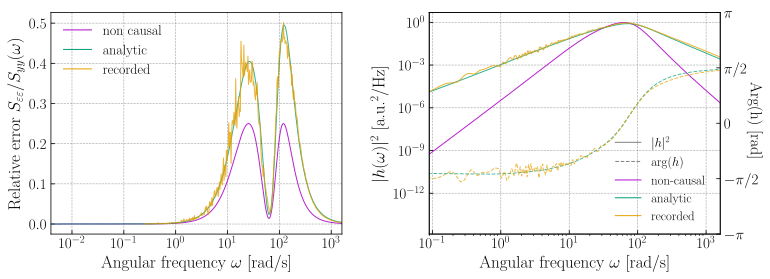

In [28]:
# Supplementary graphs part 1

def PSD_error_supplementary(ax):
    ax.semilogx(w, error_psd(H_non_causal, w), label=r'non causal',    linewidth=1, alpha = 0.9, color="#AF0CC8")
    ax.semilogx(w, error_psd(H_no_sampling, w), label=r'analytic',       linewidth=1, alpha = 0.8, color='#009E73')
    ax.semilogx(*error_psd_positive_binned_outlier(PSD_eps_recorded, Syy_est_vals, w, bins=500, z_thresh=10), label=r'recorded', linewidth=1, alpha = 0.8,color='#E69F00')

    pretty_graph(ax, x_label=r'Angular frequency $\omega$ [rad/s]', y_label=r'Relative error $S_{\varepsilon\varepsilon}/S_{yy}(\omega)$')

def PSD_h_new_supplementary(ax):
    m1, = ax.loglog(w, h_psd(H_non_causal, w), label=r'non-causal', linewidth=1, alpha=0.9, color="#AF0CC8")
    m2, = ax.loglog(w, h_psd(H_no_sampling,     w), label=r'analytic',  linewidth=1, alpha=0.8, color='#009E73')
    m3, = ax.loglog(w, h_psd(H_est,        w), label=r'recorded',   linewidth=1, alpha=0.8, color='#E69F00')

    ax.set_xlim(left=0.09)
    ax.set_xlabel(r'Angular frequency $\omega$ [rad/s]', fontsize=17)
    ax.set_ylabel(r'$|h(\omega)|^2$ [a.u.$^2$/Hz]', fontsize=17)

    ax2 = ax.twinx()
    ax2.semilogx(w, np.angle(H_no_sampling),  linestyle='--', linewidth=1, color="#009E73", alpha=0.7)
    ax2.semilogx(w, np.angle(H_est),  linestyle='--', linewidth=1, color="#E69F00", alpha=0.7)

    ax2.set_ylabel(r'Arg(h) [rad]', fontsize=16, rotation=270)

    # π-ticks on the phase axis
    ticks = np.array([-np.pi, -np.pi/2, 0.0, np.pi/2, np.pi])
    ticklbl = [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$']
    ax2.set_yticks(ticks)
    ax2.set_yticklabels(ticklbl, fontsize=15)

    ax.grid(True, which='major', color='gray', linestyle='--', linewidth=0.6, alpha=0.7)
    for side in ("top", "right", "left", "bottom"):
        ax.spines[side].set_linewidth(0.8)
    ax2.spines["right"].set_linewidth(0.8)
    ax.tick_params(axis='both', which='major', length=4, width=0.8,
                   labelsize=15, direction='in', top=False, right=False)
    ax2.tick_params(axis='y', which='major', length=4, width=0.8,
                    labelsize=15, direction='in', left=False, right=True)

    line_mag   = mlines.Line2D([], [], color='gray', linestyle='-',  linewidth=1, label=r'$|h|^2$')
    line_phase = mlines.Line2D([], [], color='gray', linestyle='--', linewidth=1, label=r'$\arg(h)$')

    handles = [line_mag, line_phase, m1, m2, m3]
    labels  = [h.get_label() for h in handles]

    leg = ax.legend(handles, labels, frameon=False, fontsize=12.8,
                    loc='lower right', ncol=1)
    for line in leg.get_lines():
        line.set_alpha(1.0)
        line.set_linewidth(1)

    ax.figure.tight_layout(pad=0)

h_size = 20
fig = plt.figure(figsize=(h_size, h_size*0.5))

# 2 rows 
fig = plt.figure(figsize=(12, 4))

# one row, two columns
gs = fig.add_gridspec(nrows=1, ncols=2, wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# your plotting functions
PSD_error_supplementary(ax1)
PSD_h_new_supplementary(ax2)

fig.tight_layout()
plt.savefig("figure_supplementary_1.svg", bbox_inches="tight")
plt.savefig("figure_supplementary_1.pdf", bbox_inches="tight")
plt.show()

In [29]:
# load previously ran data
with np.load("filter_supplementary.npz") as data:
    w_sub = data["w_sub"]
    h_grid_solve = data["h_grid_solve"]
    w_sub_conditioned = data["w_sub_conditioned"]
    h_grid_conditioned = data["h_grid_conditioned"]

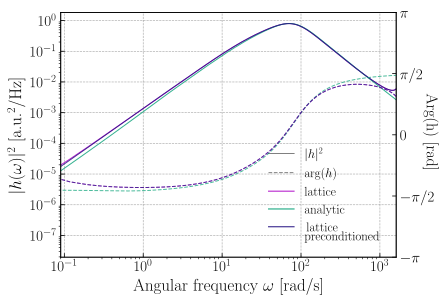

In [30]:
# supplementary graphs part 2

def PSD_h_new_supplementary_2(ax):
    m1, = ax.loglog(w_sub, h_psd(h_grid_solve, w), label=r'lattice', linewidth=1, alpha=0.9, color="#AF0CC8")
    m2, = ax.loglog(w, h_psd(H_no_sampling,     w), label=r'analytic',  linewidth=1, alpha=0.8, color='#009E73')
    m3, = ax.loglog(w_sub_conditioned, h_psd(h_grid_conditioned,     w), label=r'lattice $\newline$ preconditioned',  linewidth=1, alpha=0.8, color="#210E80")

    ax.set_xlim(left=0.09)
    ax.set_xlabel(r'Angular frequency $\omega$ [rad/s]', fontsize=17)
    ax.set_ylabel(r'$|h(\omega)|^2$ [a.u.$^2$/Hz]', fontsize=17)

    ax2 = ax.twinx()
    ax2.semilogx(w, np.angle(H_no_sampling),  linestyle='--', linewidth=1, color="#009E73", alpha=0.7)
    ax2.semilogx(w_sub, np.angle(h_grid_solve),  linestyle='--', linewidth=1, color="#AF0CC8", alpha=0.7)
    ax2.semilogx(w_sub_conditioned, np.angle(h_grid_solve), linestyle='--', linewidth=1, color="#210E80", alpha=0.7)

    ax2.set_ylabel(r'Arg(h) [rad]', fontsize=16, rotation=270)

    # π-ticks on the phase axis
    ticks = np.array([-np.pi, -np.pi/2, 0.0, np.pi/2, np.pi])
    ticklbl = [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$']
    ax2.set_yticks(ticks)
    ax2.set_yticklabels(ticklbl, fontsize=15)

    ax.grid(True, which='major', color='gray', linestyle='--', linewidth=0.6, alpha=0.7)
    for side in ("top", "right", "left", "bottom"):
        ax.spines[side].set_linewidth(0.8)
    ax2.spines["right"].set_linewidth(0.8)
    ax.tick_params(axis='both', which='major', length=4, width=0.8,
                   labelsize=15, direction='in', top=False, right=False)
    ax2.tick_params(axis='y', which='major', length=4, width=0.8,
                    labelsize=15, direction='in', left=False, right=True)

    line_mag   = mlines.Line2D([], [], color='gray', linestyle='-',  linewidth=1, label=r'$|h|^2$')
    line_phase = mlines.Line2D([], [], color='gray', linestyle='--', linewidth=1, label=r'$\arg(h)$')

    handles = [line_mag, line_phase, m1, m2, m3]
    labels  = [h.get_label() for h in handles]

    leg = ax.legend(handles, labels, frameon=False, fontsize=12.8,
                    loc='lower right', ncol=1)
    for line in leg.get_lines():
        line.set_alpha(1.0)
        line.set_linewidth(1)

    ax.figure.tight_layout(pad=0)

fig, ax = plt.subplots(figsize=(6, 4))
PSD_h_new_supplementary_2(ax)

plt.savefig("figure_supplementary_2.svg", bbox_inches="tight")
plt.savefig("figure_supplementary_2.pdf", bbox_inches="tight")

plt.show()


